<a href="https://colab.research.google.com/github/panghanwu/machine_learning_Elwing/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![models](https://www.researchgate.net/profile/Luigi_Celona2/publication/328509150/figure/fig1/AS:685633529982984@1540479180454/Ball-chart-reporting-the-Top-1-and-Top-5-accuracy-vs-computational-complexity-Top-1-and.ppm)

[Model Zoo](https://modelzoo.co/)  
[Keras Applications](https://keras.io/api/applications/)

In [1]:
import zipfile

f = zipfile.ZipFile('drive/My Drive/Colab Notebooks/Elwings_tutorial/train.zip')
f.extractall()

In [2]:
import pandas as pd
import glob


dogs = glob.glob('train/dog.*')
cats = glob.glob('train/cat.*')

df = pd.DataFrame({
    'path': dogs + cats,
    'target': [0] * len(dogs) + [1] * len(cats)
})
df

,path,target
0,train/dog.9287.jpg,0
1,train/dog.2877.jpg,0
2,train/dog.8792.jpg,0
3,train/dog.4978.jpg,0
4,train/dog.981.jpg,0
...,...,...
24995,train/cat.10328.jpg,1
24996,train/cat.517.jpg,1
24997,train/cat.257.jpg,1
24998,train/cat.10261.jpg,1


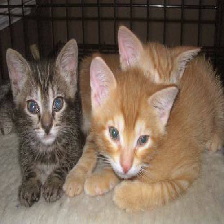

In [3]:
from tensorflow.keras.preprocessing.image import load_img
import random

idx = random.randint(0,24999)
load_img(df['path'][idx], target_size=(224,224))


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

x, y = np.array(df["path"]), np.array(df["target"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(22500,)
(2500,)
(22500,)
(2500,)


In [5]:
from tensorflow.keras.applications import vgg16

cnn = vgg16.VGG16(include_top=False, input_shape=(224,224,3))
cnn.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
cnn.layers  # list

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization

# freeze一定要在compile之前
for l in cnn.layers:
  l.trainable = False

mlp = [
    BatchNormalization(),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(2, activation="softmax")  # 使用多輸出 日後好擴充
]
model = Sequential(cnn.layers + mlp)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [8]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer=Adam(),
       metrics=["accuracy"])

In [9]:
"""
Generator
just demo
"""

def test():
  for i in range(10):
    yield (i+1)**2

g = test()
for n in g:
  print(n)
for n in g:
  print(n)
for n in test():
  print(n)

1
4
9
16
25
36
49
64
81
100
1
4
9
16
25
36
49
64
81
100


In [10]:
def getdata(x, y, batch=20):
  idx = np.random.randint(0,x.shape[0], size=batch)
  origin_x, batch_x, batch_y = [], [], y[idx]
  for p in x[idx]:
    img = load_img(p, target_size=(244,244))
    img_np = np.array(img)
    origin_x.append(img_np)
    img_pre = vgg16.preprocess_input(img_np)  # vgg16的預處理方法
    batch_x.append(img_pre)
  return (np.array(origin_x), np.array(batch_x), np.array(batch_y))

test_origin, test_x, test_y = getdata(x_train, y_train, 20)
print(test_origin.shape)
print(test_x.shape)
print(test_y.shape)


(20, 244, 244, 3)
(20, 244, 244, 3)
(20,)


In [11]:
test_img, test_x, test_y = getdata(x_test, y_test, 200)

for i in range(20):
    print("-" * 15, i, "-" * 15)
    train_img, train_x, train_y = getdata(x_train, y_train, 20)
    result = model.train_on_batch(train_x, train_y)
    print("Train:", result)
    result = model.test_on_batch(test_x, test_y)
    print("Validate:", result)

--------------- 0 ---------------
Train: [0.8948037028312683, 0.6499999761581421]
Validate: [4.55372953414917, 0.8149999976158142]
--------------- 1 ---------------
Train: [1.5880025625228882, 0.699999988079071]
Validate: [2.6555564403533936, 0.8999999761581421]
--------------- 2 ---------------
Train: [0.26855021715164185, 0.8999999761581421]
Validate: [4.830700397491455, 0.8500000238418579]
--------------- 3 ---------------
Train: [0.250455766916275, 0.8999999761581421]
Validate: [5.125009536743164, 0.8550000190734863]
--------------- 4 ---------------
Train: [0.278480589389801, 0.8999999761581421]
Validate: [4.666048526763916, 0.8700000047683716]
--------------- 5 ---------------
Train: [0.033358488231897354, 1.0]
Validate: [4.541810989379883, 0.875]
--------------- 6 ---------------
Train: [0.055810146033763885, 0.949999988079071]
Validate: [4.484739303588867, 0.8799999952316284]
--------------- 7 ---------------
Train: [0.009245616383850574, 1.0]
Validate: [4.245785713195801, 0.87

In [12]:
# model.predict(train_x)
test_img, test_x, test_y = getdata(x_test, y_test, 1000)
model.evaluate(test_x, test_y)

32/32 [==============================] - 3s 87ms/step - loss: 1.8120 - accuracy: 0.9300


[1.811952829360962, 0.9300000071525574]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


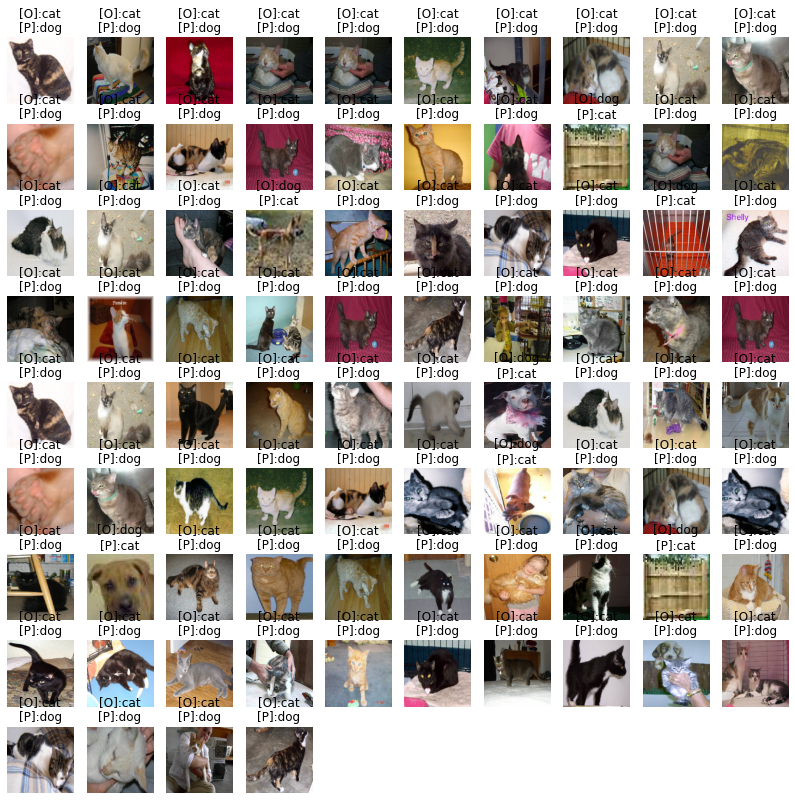

In [13]:
import matplotlib.pyplot as plt
test_img, test_x, test_y = getdata(x_test, y_test, 1000)
pre = model.predict_classes(test_x)
trains = ["dog", "cat"]

idx = np.nonzero(pre != test_y)[0]
idx = idx[:200]
false_img = test_img[idx]
false_label = test_y[idx]
false_pre = pre[idx]

plt.figure(figsize=(14, 14))
width = 10
height = len(false_img) // width + 1
for i in range(len(false_img)):
    plt.subplot(height, width, i+1)
    title = "[O]:{}\n[P]:{}".format(trains[false_label[i]], trains[false_pre[i]])
    plt.title(title)
    plt.axis("off")
    plt.imshow(false_img[i])

輸入網址:https://eatliver.b-cdn.net/wp-content/uploads/2020/08/pixelated-cats1.jpg


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


dog 的機率是: 0.0
cat 的機率是: 1.0
應該是: cat


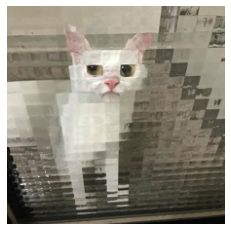

In [14]:
import PIL
import requests
url = input("輸入網址:")
h = {
    "user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36"
}
response = requests.get(url, stream=True, verify=False, headers=h)
img = PIL.Image.open(response.raw).resize((224, 224))
img_np = np.array(img)
test = vgg16.preprocess_input(img_np.reshape(1, 224, 224, 3))
probs = model.predict(test)[0]
for i, p in enumerate(probs):
    print(trains[i], "的機率是:", round(p, 3))
ans = model.predict_classes(test)[0]
print("應該是:", trains[ans])
plt.axis('off')
plt.imshow(img_np)